**Name: Nidhi Rajkumar Saini**

In [1]:
import pandas as pd
import glob
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import math
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
activities = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
testSize = {'bending1':2, 'bending2':2, 'cycling':3, 'lying':3, 'sitting':3, 'standing':3, 'walking':3}
features = ['min','max','mean','median','std','1st quart', '3rd quart']
multiclassVals = pd.DataFrame(columns=['Best l', 'Train Error', 'Test Error', 'F1-score'])
binaryclassVals = pd.DataFrame(columns=['Best l', 'Train Error', 'Test Error', 'F1-score'])

In [3]:
# get list of filenames for Test and Train data
def getFiles(testSize):
    testFiles = []
    trainFiles = []
    for activity in activities:
        files = glob.glob("..\data\AReM\{}\*.csv".format(activity))
        files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        testFiles += files[:testSize[activity]]
        trainFiles += files[testSize[activity]:]
    return testFiles,trainFiles

In [4]:
# read a csv file into a dataframe
def readData(csv):
    with open(csv) as csvfd:
        firstLine = csvfd.readlines()[5]
        csvfd.close()
        sep = firstLine[1]
        if sep == 32 or sep == ' ' :
            instance = pd.read_csv(csv, skiprows = 5, sep = '\s+', header = None)
        else:
            instance = pd.read_csv(csv, skiprows = 5, header = None)
    return instance

In [5]:
# combine csv files horizontally to a single dataframe
def combinetoDFs(fileList):
    mergedDF = readData(fileList[0])
    for file in fileList[1:]:
        mergedDF = pd.concat([mergedDF, readData(file)], axis=0)
    return mergedDF

In [6]:
# bootstrap method for standard deviation
def applyBootstrap(data,repetitions):
    # Create an empty array to store replicates
    bs_replicates = []
    
    # Create bootstrap replicates as much as size
    for i in range(repetitions):
        # Create a bootstrap sample
        bs_sample = data.sample(n = len(data), replace = True, random_state = None)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates.append(np.std(bs_sample))
    
    return bs_replicates

In [7]:
# split a dataframe to multiple dataframes
def getSplitDFs(df, splitLen):
    dfs = []
    for each in np.array_split(df, splitLen):
        dfs.append(pd.DataFrame(each))
    for each in range(len(dfs)):
        dfs[each].reset_index(drop=True, inplace=True)
    return dfs

In [8]:
# Compute desired measures: minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for a dataframe
def computeMeasures(colnum,df,fileNo,measures):
    res = []
    cols = []
    descr = df[colnum].describe()
    for each in measures:
        cols.append(each)
        if 'median'== each:
            res.append(descr['50%'])
        elif '1st quart' == each:
            res.append(descr['25%'])
        elif '3rd quart' == each:
            res.append(descr['75%'])
        else:
            res.append(df[colnum].describe()[each])
    
    df1 = pd.DataFrame(columns=cols)
    df1.loc[fileNo] = res
    return df1

In [9]:
# create a dataframe of time-domain features
def getfeatureDF(files, splitSize, measures):
    filemergedDF = pd.DataFrame()
    fileNo = 0
    for file in files:
        df_initial = readData(file)
        df_initial = df_initial.iloc[:,1:]
        splitDFs = getSplitDFs(df_initial,splitSize)
        mergedDF = pd.DataFrame()
        for i in range(len(splitDFs)):
            mergedDF = pd.concat([mergedDF,computeMeasures(1,splitDFs[i],fileNo,measures)], axis = 1)
            for colnum in range(2, len(df_initial.columns)+1):
                mergedDF = pd.concat([mergedDF,computeMeasures(colnum,splitDFs[i],fileNo,measures)], axis = 1)
        fileNo += 1
        filemergedDF = pd.concat([filemergedDF,mergedDF], axis = 0)

    cols = []
    for each in list(range(1,len(df_initial.columns)*splitSize+1)):
        for m in measures:
            cols.append(m+str(each))
    filemergedDF.columns = cols

    return filemergedDF

In [10]:
# Add label columns: isBending (to separate Bending from other activities), class (to depict type of activity)
def getlabels(files):
    ycol = pd.DataFrame()
    for file in files:
        activity = os.path.normpath(file).split("\\")[-2]
        _activity = "bending" if(activity=="bending1" or activity=="bending2") else activity
        isbending = 1 if _activity=="bending" else 0
        ycol = pd.concat([ycol, pd.DataFrame([[isbending,activity]])], axis=0)
    ycol.reset_index(drop=True, inplace=True)
    ycol.columns = ['isBending', 'class']
    return ycol

In [11]:
# Logistic Regression with Recursive Feature Elimination (RFE) and Cross Validation (CV)
def rfe_cv(x,y,fold):
    rfe = RFE(estimator=LogisticRegression())
    model = LogisticRegression(max_iter=10 , C=100000)
    cv = StratifiedKFold(n_splits=fold, shuffle = True)
    f1score = []
    
    # Run RFE with 5-fold Cross validation
    for train_idx, validation_idx in cv.split(x, y):
        rfe = rfe.fit(x.loc[train_idx], y.loc[train_idx])
        model = model.fit(x.loc[train_idx][x.columns[rfe.support_].tolist()], y.loc[train_idx])
        ypred = model.predict(x.loc[validation_idx][x.columns[rfe.support_].tolist()])
        f1score.append(f1_score(y.loc[validation_idx], ypred, average='weighted'))   
    
    # get feature names selected in current model
    feature_importance = list(zip(x.columns, rfe.support_))
    new_features = []
    for key,value in enumerate(feature_importance):
        if(value[1]) == True:
            new_features.append(value[0])

    return (np.mean(f1score), new_features, model)

In [12]:
# Compute metrics: Confusion matrix, ROC, AUC and plot it
def metrics(y, predictions):
    print("Confusion Matrix:\n",confusion_matrix(y, predictions))
    fpr, tpr, thresholds = roc_curve(y, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def multi_cm(model, xtest, ytest):
    predict = model.predict(xtest)
    cm = confusion_matrix(ytest, predict, activities)
    print(cm)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + activities)
    ax.set_yticklabels([''] + activities)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [14]:
def plot_multiclass_roc(clf, X_test, y_test, figsize=(8, 6)):
    t = str(type(clf))
    y_score = clf.decision_function(X_test) if not("naive_bayes" in t) else clf.predict_proba(X_test)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies - label encoding
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(len(activities)):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(len(activities)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], activities[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Time Series Classification

## Loading the AReM data

In [15]:
allFiles = []

for activity in activities:
    files = glob.glob("..\data\AReM\{}\*.csv".format(activity))
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    allFiles += files

df = combinetoDFs(allFiles)
df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
print("Read {} files in total from {} activities {}".format(len(allFiles),len(activities),activities))
df

Read 88 files in total from 7 activities ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']


,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.30
1,250,39.25,0.43,23.00,0.00,33.00,0.00
2,500,39.25,0.43,23.25,0.43,33.00,0.00
3,750,39.50,0.50,23.00,0.71,33.00,0.00
4,1000,39.50,0.50,24.00,0.00,33.00,0.00
...,...,...,...,...,...,...,...
475,118750,34.50,6.18,9.00,3.56,12.67,4.19
476,119000,25.75,6.02,13.75,2.05,16.00,1.58
477,119250,31.50,3.35,10.25,5.12,16.25,2.95
478,119500,33.75,2.77,14.00,3.24,13.75,0.43


In [16]:
df.shape

(42239, 7)

## Split data into Train and Test

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [17]:
testFiles, trainFiles = getFiles(testSize)
print("List of test files\n")
for filename in testFiles:
    print(filename)
testDF = combinetoDFs(testFiles)
testDF.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
trainDF = combinetoDFs(trainFiles)
trainDF.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

List of test files

..\data\AReM\bending1\dataset1.csv
..\data\AReM\bending1\dataset2.csv
..\data\AReM\bending2\dataset1.csv
..\data\AReM\bending2\dataset2.csv
..\data\AReM\cycling\dataset1.csv
..\data\AReM\cycling\dataset2.csv
..\data\AReM\cycling\dataset3.csv
..\data\AReM\lying\dataset1.csv
..\data\AReM\lying\dataset2.csv
..\data\AReM\lying\dataset3.csv
..\data\AReM\sitting\dataset1.csv
..\data\AReM\sitting\dataset2.csv
..\data\AReM\sitting\dataset3.csv
..\data\AReM\standing\dataset1.csv
..\data\AReM\standing\dataset2.csv
..\data\AReM\standing\dataset3.csv
..\data\AReM\walking\dataset1.csv
..\data\AReM\walking\dataset2.csv
..\data\AReM\walking\dataset3.csv


In [18]:
testDF.shape

(9120, 7)

In [19]:
trainDF.shape

(33119, 7)

## Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

**Ans:** In classification of time series, time-domain features include simple statistical features such as:<br>
- Means in each of the d dimensions
- Standard deviations of the d dimensions
- Skewness, Kurtosis and Higher order moments of the d dimensions
- Maximum and Minimum values
- $k^{th}$ quartile<br>

Futhermore, frequencies of peak in amplitude in discrete fourier transform are also used in times series classification.

### Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.

In [20]:
featureDF = getfeatureDF(allFiles, 1, ['min', 'max', 'mean', 'median', 'std', '1st quart', '3rd quart'])

featureDF = pd.concat([featureDF,getlabels(allFiles)], axis = 1)
featureDF.index.name = 'Instance'

featureDF

,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,mean2,...,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6,isBending,class
Instance,,,,,,,,,,,,,,,,,,,,,
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,1,bending1
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,1,bending1
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,1,bending1
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,1,bending1
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,1,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,0,walking
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,0,walking
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,0,walking


### Estimate the standard deviation of each of the time-domain features you extracted from the data.

In [21]:
print("The standard deviation of each of the time-domain features extracted from the data is as follows:")
np.std(featureDF)

The standard deviation of each of the time-domain features extracted from the data is as follows:


min1          9.515445
max1          4.369322
mean1         5.305314
median1       5.409056
std1          1.762056
1st quart1    6.118526
3rd quart1    5.109643
min2          0.000000
max2          5.033882
mean2         1.565194
median2       1.404197
std2          0.879068
1st quart2    0.940994
3rd quart2    2.113157
min3          2.939616
max3          4.847358
mean3         3.985540
median3       4.013397
std3          0.941316
1st quart3    4.196608
3rd quart3    4.147858
min4          0.000000
max4          2.171183
mean4         1.159470
median4       1.139058
std4          0.455631
1st quart4    0.838813
3rd quart4    1.543658
min5          6.089107
max5          5.708524
mean5         5.643253
median5       5.780655
std5          1.019058
1st quart5    6.061727
3rd quart5    5.500200
min6          0.045577
max6          2.504568
mean6         1.148232
median6       1.080284
std6          0.514668
1st quart6    0.754261
3rd quart6    1.514918
isBending     0.354829
dtype: floa

#### Build a 90% bootstrap confidence interval for the standard deviation of each feature.

In [22]:
print("90% bootstrap confidence interval for the standard deviation of each feature is as follows:\n")
for each in featureDF.columns[:-2]:
    bs_result = applyBootstrap(featureDF[each],1000)
    # 90% confidence interval
    lower = np.percentile(bs_result,5)
    right = np.percentile(bs_result,95)
    print("{}: ({}, {})".format(each,round(lower,2),round(right,2)))

90% bootstrap confidence interval for the standard deviation of each feature is as follows:

min1: (8.19, 10.77)
max1: (3.34, 5.25)
mean1: (4.68, 5.84)
median1: (4.78, 5.93)
std1: (1.56, 1.92)
1st quart1: (5.56, 6.61)
3rd quart1: (4.26, 5.82)
min2: (0.0, 0.0)
max2: (4.62, 5.37)
mean2: (1.39, 1.7)
median2: (1.23, 1.53)
std2: (0.8, 0.94)
1st quart2: (0.82, 1.03)
3rd quart2: (1.87, 2.29)
min3: (2.74, 3.08)
max3: (4.14, 5.43)
mean3: (3.42, 4.43)
median3: (3.4, 4.5)
std3: (0.76, 1.13)
1st quart3: (3.58, 4.69)
3rd quart3: (3.53, 4.71)
min4: (0.0, 0.0)
max4: (1.96, 2.34)
mean4: (1.07, 1.22)
median4: (1.05, 1.19)
std4: (0.42, 0.48)
1st quart4: (0.77, 0.89)
3rd quart4: (1.43, 1.62)
min5: (4.44, 7.58)
max5: (4.79, 6.56)
mean5: (4.42, 6.69)
median5: (4.54, 6.86)
std5: (0.81, 1.21)
1st quart5: (4.76, 7.09)
3rd quart5: (4.34, 6.56)
min6: (0.0, 0.08)
max6: (2.26, 2.75)
mean6: (1.06, 1.21)
median6: (0.98, 1.14)
std6: (0.48, 0.54)
1st quart6: (0.69, 0.81)
3rd quart6: (1.39, 1.59)


 ### Select the three most important time-domain features.

Text(0.5, 1.0, 'Distribution plot for Time domain features of each time series')

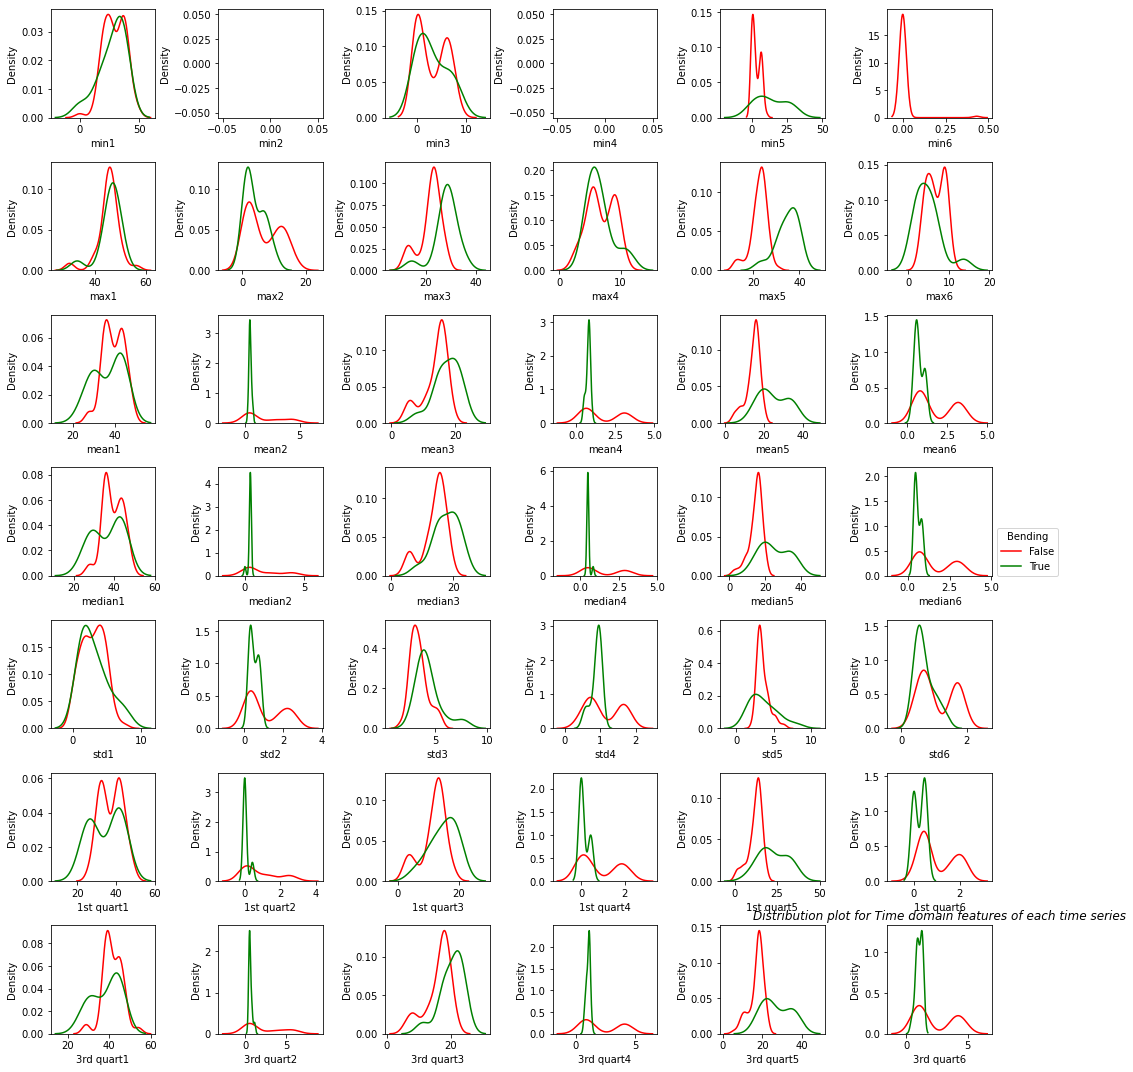

In [23]:
plt.figure(figsize=(15,15))
for j, feature in enumerate(features, start = 1):
    for i in range(1,len(features)):    
        plt.subplot(7,6,6*j+i-6)
        sns.distplot(featureDF[featureDF['isBending'] == 0][feature+str(i)], kde = True, hist = False, color="red", label="False")
        sns.distplot(featureDF[featureDF['isBending'] == 1][feature+str(i)] , kde = True, hist = False, color="green", label="True")
        if 6*j+i-6 == 24: 
            plt.legend(title = 'Bending',loc=(1.05,0))
plt.tight_layout()
plt.title('Distribution plot for Time domain features of each time series',style = 'oblique')

Taking "Bending" activity as example, the 3 most important time-domain features according to my judgement are mean, median and 3rd quartile as the plot for True and False values are having a more separated distribution as evident by the above distribution plots of the time-domain features for each time series.

In [24]:
selected_features = ['mean', 'median', '3rd quart']

## Binary Classification Using Logistic Regression

### Depict scatter plots of the features you specified in 1.3.4 extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

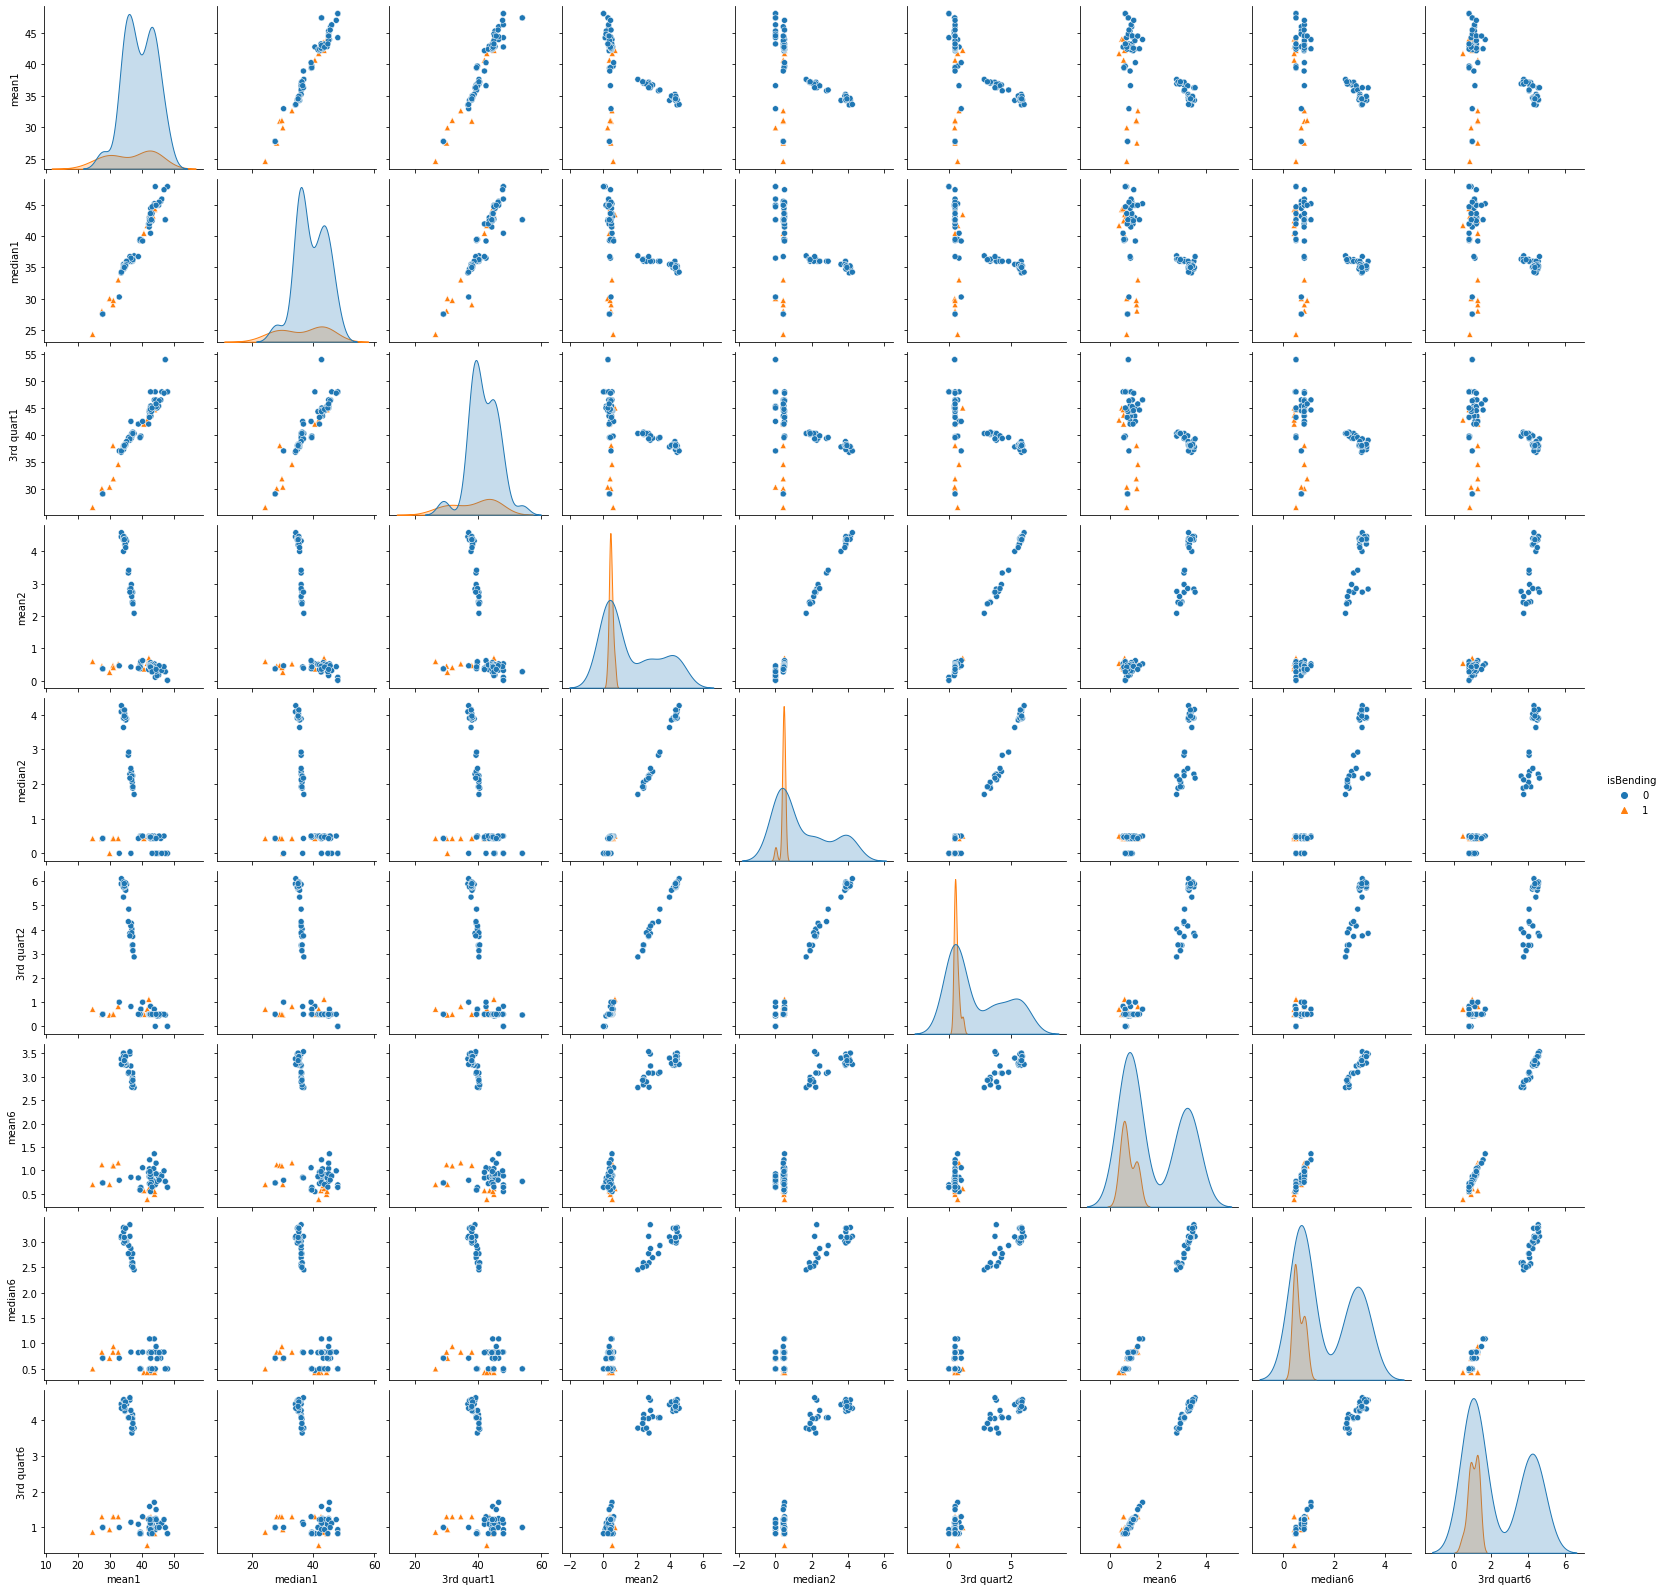

In [25]:
sel = []
for ts in ['1','2','6']:
    for f in selected_features:
        sel.append(f+ts)
dfnew = featureDF[sel+['isBending']]
sns.pairplot(dfnew, kind='scatter', hue ='isBending',markers=["o", "^"])

### Break each time series in your training set into two (approximately) equal length time series.

In [26]:
# get time-domain features for training set after breaking into 2 equal length time series
featureDF2 = getfeatureDF(trainFiles, 2, selected_features)
# Add label columns
featureDF2 = pd.concat([featureDF2,getlabels(trainFiles)], axis = 1)
featureDF2.index.name = 'Instance'
featureDF2

,mean1,median1,3rd quart1,mean2,median2,3rd quart2,mean3,median3,3rd quart3,mean4,...,median10,3rd quart10,mean11,median11,3rd quart11,mean12,median12,3rd quart12,isBending,class
Instance,,,,,,,,,,,,,,,,,,,,,
0,44.057167,44.500,45.0000,0.381042,0.470,0.5000,23.096792,24.000,24.0000,0.493458,...,0.43,0.7100,34.883375,36.000,36.2500,0.388333,0.000,0.7100,1,bending1
1,43.278875,45.000,45.2500,0.673292,0.485,1.0000,23.141250,23.750,24.8125,0.808042,...,0.87,1.4800,30.965708,30.415,33.7500,0.586083,0.470,0.8700,1,bending1
2,41.621208,42.330,44.2500,0.623083,0.500,0.8300,19.081458,19.500,24.0000,1.115083,...,0.47,0.8300,29.635833,29.750,30.5625,0.347500,0.430,0.5000,1,bending1
3,44.117042,45.000,45.0000,0.250042,0.000,0.5000,17.744167,18.000,20.0000,1.123000,...,0.43,0.8225,22.850875,23.250,23.7500,0.543875,0.500,0.7100,1,bending1
4,43.486208,43.710,44.5000,0.378667,0.470,0.5000,16.397250,16.875,18.0000,0.662958,...,0.47,0.8875,21.882042,21.750,23.5000,0.585750,0.500,0.8300,1,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,34.000,36.8125,4.408083,4.195,5.8700,15.445333,15.330,17.3125,3.271417,...,3.08,4.3200,15.755958,15.875,18.0625,3.290292,3.155,4.4525,0,walking
65,34.036750,34.415,37.7500,4.778292,4.030,6.5050,15.177083,15.250,17.0000,3.394083,...,2.95,4.0600,15.520375,15.750,17.7500,3.321417,3.155,4.3950,0,walking
66,34.033875,35.000,37.5000,4.574625,4.470,6.0300,15.340417,15.250,17.2500,3.025417,...,2.87,3.9775,15.218417,15.000,17.2500,3.432208,3.255,4.5125,0,walking


#### Repeat the experiment in 1.4.1, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12.

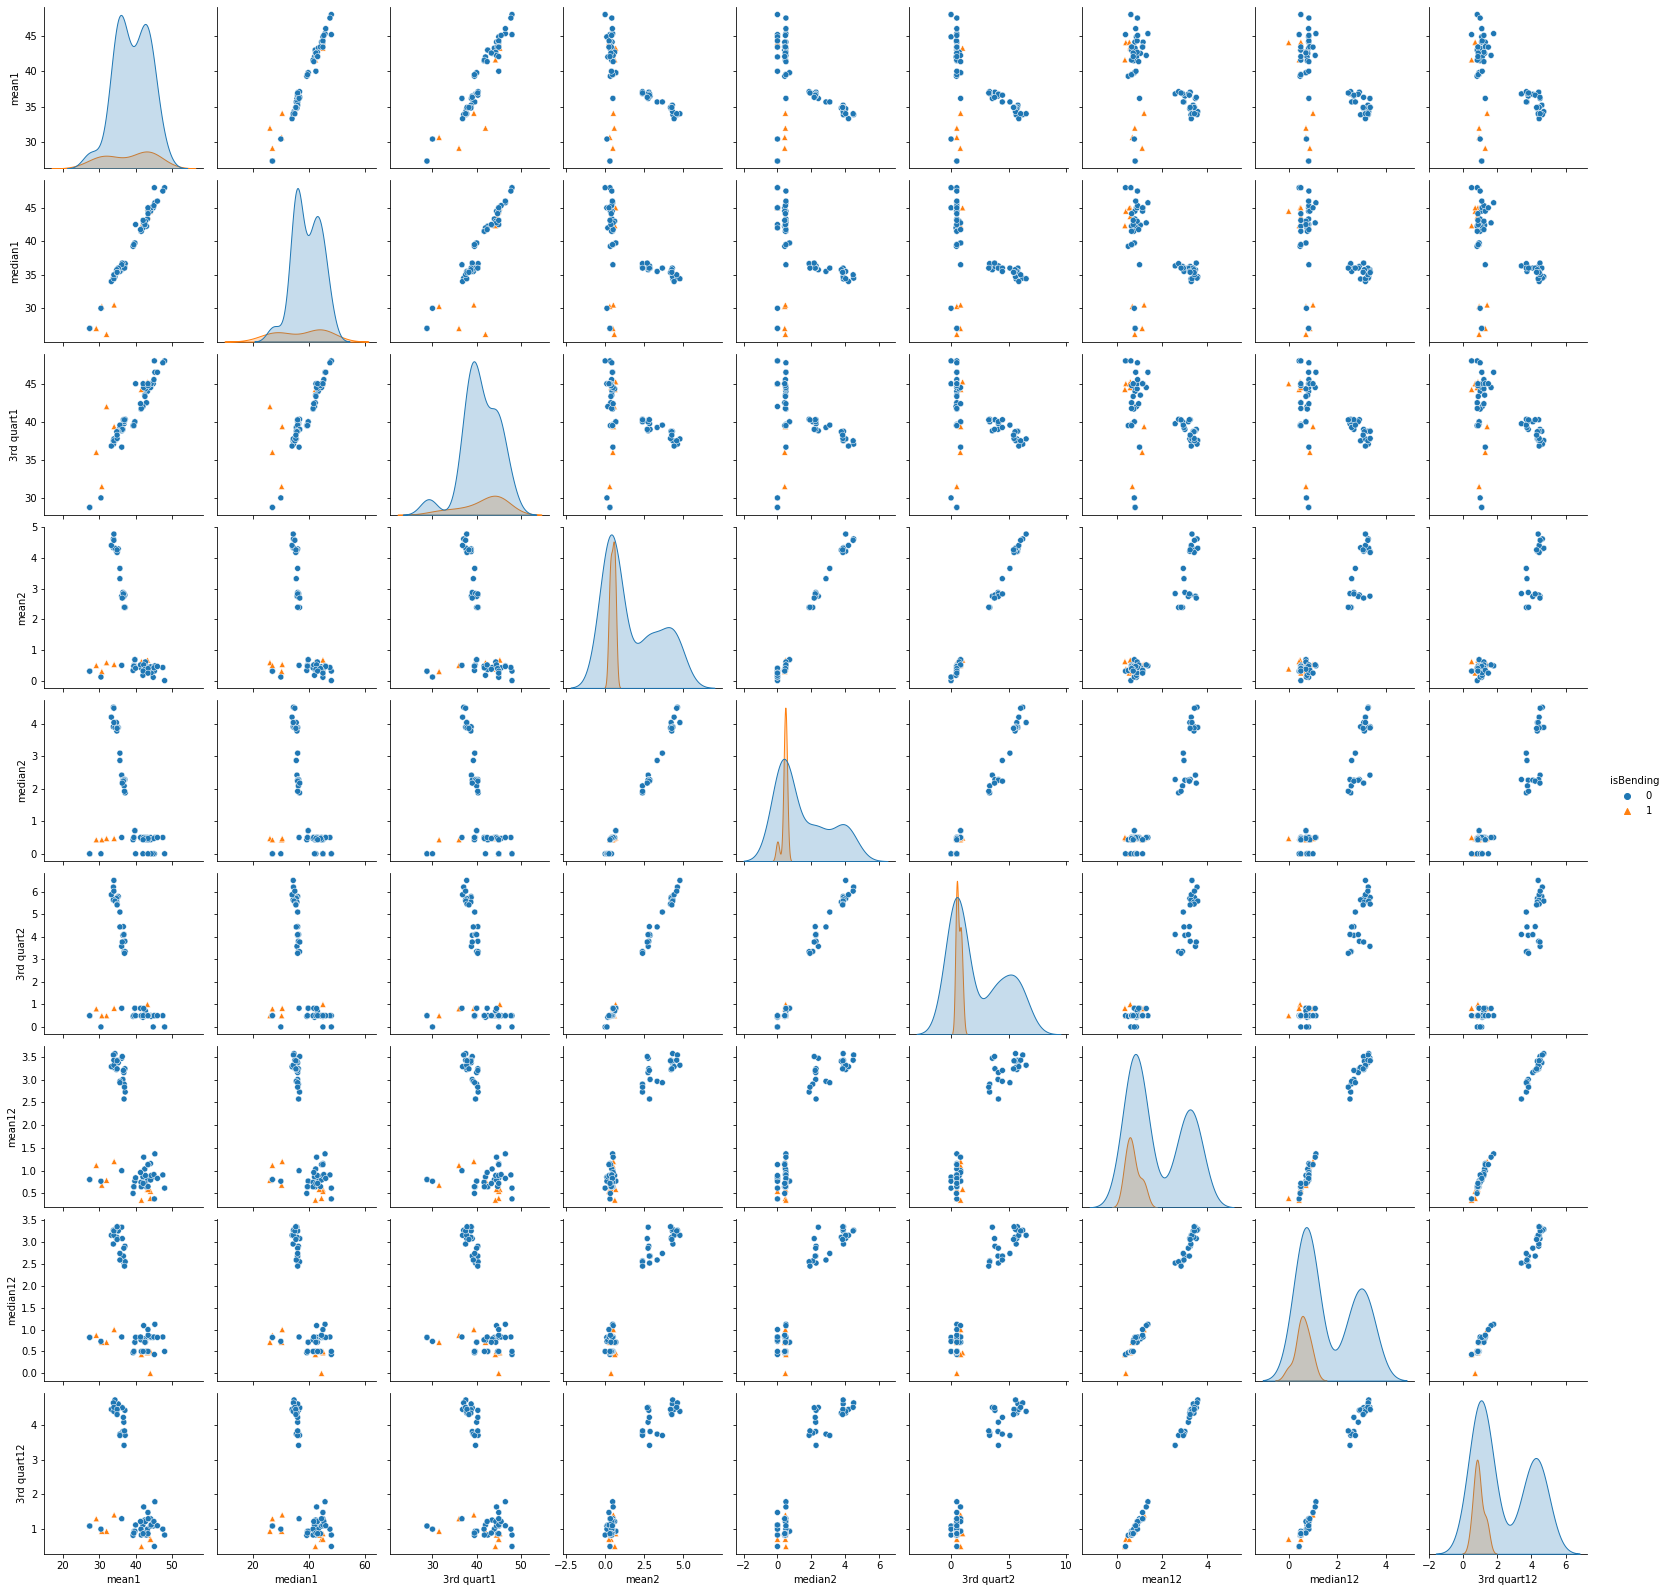

In [27]:
sel = []
for ts in ['1','2','12']:
    for f in selected_features:
        sel.append(f+ts)
dfnew = featureDF2[sel+['isBending']]
sns.pairplot(dfnew, kind='scatter', hue ='isBending', markers=["o", "^"])

#### Do you see any considerable difference in the results with those of 1.4.1?

In this question, we break time series into 2 equal time length, the scatterplots of time-domain features of series 1, 2 and 12 become more sparse than original, because the whole period in 1 length-time data breaks into 2 periods in 2 length-time data. We can observe that even though we break the times series into 2 equal lengths, first time length still has similar pattern like the overall but more sparse. From the distribution of each time-domain features in 2 time-length scatterplot, the plots are slightly different, but overall it looks similar with that of the whole time length scatterplot in 1.4.1.

### Logistic Regression with Recursive Feature Elimination and 5-fold Stratified Cross Validation to find the best number of equal length and features to break time series.

In [28]:
# finding best value of l
L = 20
y = getlabels(trainFiles)
model_params = []

for l in range(1,L+1):
    x = getfeatureDF(trainFiles, l, selected_features)
    model_params.append(rfe_cv(x,y.iloc[:,:1],5))
    print(l, model_params[-1][0])

1 0.9450740563784041
2 0.9540831342570474
3 0.937689440993789
4 0.9704513457556937
5 0.9704640866379997
6 0.986845039018952
7 0.9550476190476191
8 0.9704640866379997
9 0.9450740563784041
10 0.9287058448797578
11 0.9704513457556935
12 0.9476821149864628
13 0.941879917184265
14 0.9540831342570474
15 0.9704513457556935
16 0.9704513457556937
17 0.9704640866379997
18 0.9508571428571428
19 0.9296703296703296
20 0.9714285714285715


In [29]:
# get pair (l, p) and F1-score of the best model
zip_model_params = list(zip(list(range(1,L+1)), model_params))
sort_model_params = sorted(zip_model_params, key=lambda x: -x[1][0])
best_model_l = sort_model_params[0][0]
best_model_f1 = sort_model_params[0][1][0]
best_model_features = sort_model_params[0][1][1]
best_model = sort_model_params[0][1][2]
print("Best model with F1-score and Feature Names is:\n")
print(sort_model_params[0][1])

Best model with F1-score and Feature Names is:

(0.986845039018952, ['3rd quart2', 'mean5', 'median5', '3rd quart5', 'mean6', '3rd quart6', '3rd quart7', 'mean8', '3rd quart8', '3rd quart9', '3rd quart10', 'mean11', 'median11', '3rd quart11', '3rd quart12', '3rd quart13', '3rd quart14', 'mean16', 'median16', '3rd quart16', 'mean18', 'median18', '3rd quart18', '3rd quart19', '3rd quart20', 'mean22', 'median22', '3rd quart22', 'mean23', 'median23', '3rd quart24', 'mean25', 'median25', '3rd quart25', '3rd quart26', 'median27', 'mean28', 'median28', '3rd quart28', 'mean29', 'median29', 'mean30', '3rd quart30', '3rd quart31', '3rd quart32', 'mean33', 'median33', '3rd quart33', '3rd quart34', 'mean35', 'median35', '3rd quart35', 'mean36', '3rd quart36'], LogisticRegression(C=100000, max_iter=10))


In [30]:
trainX = getfeatureDF(trainFiles, best_model_l, selected_features)[best_model_features]
train_accuracy = round(cross_val_score(best_model, trainX, y.iloc[:,:1], cv=5).mean(),2)
train_error = round(1 - train_accuracy, 2)
print("Cross validation accuracy:",train_accuracy)
print("\nThe value of the pair (l, p), where p is the number of features used in the best Logistic Regression model is ({}, {}) having F1-score = {}.".format(best_model_l, len(best_model_features), round(best_model_f1,2) ))

Cross validation accuracy: 0.99

The value of the pair (l, p), where p is the number of features used in the best Logistic Regression model is (6, 54) having F1-score = 0.99.


#### Explain what the right way and the wrong way are to perform cross-validation in this problem.

In this problem, we break our training dataset into 5 folds, and build a logistic regression model with recursive feature elimination on train dataset and use validation dataset to validate our training model. The wrong way to perform cross-validation in this problem is to build a model and run feature elimination with all the training data before cv process, and then use 5-fold cross validation to test the model. The problem in this way is that model building and feature selection should be included in cross validation, not outside the cv process. By doing the wrong way, the model built in feature selection will have already seen the validation data, and will eventually have a good performance in predicting validation data.

### Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression $β_i$’s as well as the p-values associated with them.

In [31]:
params = np.append(best_model.intercept_,best_model.coef_)
X = trainX
y = y.iloc[:,:1]
predictions = best_model.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
predictions = predictions.reshape(-1,1)
MSE = (sum((np.asarray(y)-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Variable"], myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-values"] = [list(y.columns)+list(X.columns),params,sd_b,ts_b,p_values]
print("Intercept: isBending")
myDF3

Intercept: isBending


,Variable,Coefficients,Standard Errors,t values,P-values
0,isBending,-0.0017,1.044,-0.002,0.999
1,3rd quart2,-0.0287,0.204,-0.141,0.890
2,mean5,0.1169,0.255,0.458,0.654
3,median5,0.1133,0.198,0.572,0.576
4,3rd quart5,0.1171,0.071,1.658,0.119
5,mean6,-0.0172,0.764,-0.023,0.982
6,3rd quart6,-0.0220,0.535,-0.041,0.968
7,3rd quart7,-0.0529,0.072,-0.739,0.472
8,mean8,-0.0204,0.605,-0.034,0.974
9,3rd quart8,-0.0272,0.396,-0.069,0.946


Confusion Matrix:
 [[59  1]
 [ 0  9]]


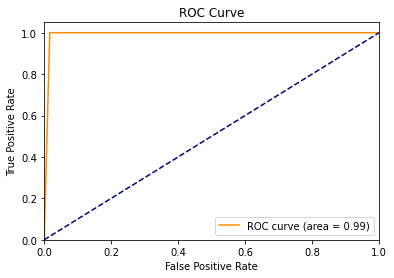

In [32]:
metrics(y, predictions)

### Test the classifier on the test set after breaking the time series in the test set into the same number of time series into which you broke your training set.

In [33]:
testX = getfeatureDF(testFiles, best_model_l, selected_features)[best_model_features]
testY = getlabels(testFiles).iloc[:,:1]
testpredictions = best_model.predict(testX)
test_f1score = f1_score(testY, testpredictions, average='weighted')
print('l:{}'.format(best_model_l))
print('F1 score: %0.2f '%test_f1score)
print("Confusion matrix:\n",confusion_matrix(testY, testpredictions))

l:6
F1 score: 1.00 
Confusion matrix:
 [[15  0]
 [ 0  4]]


#### Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [34]:
test_accuracy = best_model.score(testX,testY)
test_error = round(1 - test_accuracy, 2)
print("We observe that cross-validation accuracy on the train set is {} and accuracy on the test set is {}. Comparing them, we observe that the test set accuracy values are close to that of train set accuracy.".format(train_accuracy, test_accuracy))

We observe that cross-validation accuracy on the train set is 0.99 and accuracy on the test set is 1.0. Comparing them, we observe that the test set accuracy values are close to that of train set accuracy.


In [35]:
bestl = str(best_model_l).strip()
binaryclassVals.loc['Logistic regression with RFE and CV'] = [bestl, train_error, test_error, test_f1score]

### Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes the classes seem to be well-separated as the instances belonging to each classes are separated in such a way from each other so as to be easily (accurately) differentiated using one or more features. The logistic regression model is having unstable parameter estimates due to this scenario. <br>
On training the model with default parameters, it fails to converge and gives error: Total number of iteration reached limit. After encountering this problem of instability of the logistic regression model because of linearly separable classes, I modified the Max-Iter parameter in logistic regression to stop the algorithm immaturely and prevent from its instability. 

### From the confusion matrices you obtained, do you see imbalanced classes?

Yes, the above confusion matrices of train and test set show imbalanced classes. Thus, we need to build a logistic regression model based on case-control sampling and adjust its parameters.

#### Build a logistic regression model based on case-control sampling and adjust its parameters.

In [36]:
downsample_model_params = []
# Find best l for downsampled data
for l in range(1,L+1):
    trainx = getfeatureDF(trainFiles, l, selected_features)
    y = getlabels(trainFiles).iloc[:,:1]
    # Indicies of each class' observations
    i_class0 = np.where(y == 0)[0]
    i_class1 = np.where(y == 1)[0]
    # Number of observations in each class
    n_class0 = len(i_class0)
    n_class1 = len(i_class1)

    # For every observation of class 1, randomly sample from class 0 without replacement
    i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)

    # Join together class 0's target vector with the downsampled class 1's target vector
    y = pd.DataFrame(np.vstack((y.loc[i_class0_downsampled], y.loc[i_class1])), columns = y.columns)
    x = pd.DataFrame(np.vstack((trainx.loc[i_class0_downsampled], trainx.loc[i_class1])),columns = trainx.columns)
    downsample_model_params.append(rfe_cv(x, y, 5))
    print(l, downsample_model_params[-1][0])

1 0.7466666666666667
2 0.8466666666666667
3 1.0
4 1.0
5 1.0
6 0.9466666666666667
7 0.9466666666666667
8 1.0
9 0.9466666666666667
10 0.8933333333333333
11 0.8933333333333333
12 0.8933333333333333
13 0.8800000000000001
14 0.9466666666666667
15 1.0
16 0.9466666666666667
17 0.9066666666666666
18 1.0
19 1.0
20 0.9466666666666667


In [37]:
zip_downsample_model_params = list(zip(list(range(1,L+1)), downsample_model_params))
sort_downsample_model_params = sorted(zip_downsample_model_params, key=lambda x: -x[1][0])
downsample_model_l = sort_downsample_model_params[0][0]
downsample_model_f1 = sort_downsample_model_params[0][1][0]
downsample_model_features = sort_downsample_model_params[0][1][1]
downsample_model = sort_downsample_model_params[0][1][2]
print("Best model with l, F1-score and Feature Names is:\n")
print(sort_downsample_model_params[0])

Best model with l, F1-score and Feature Names is:

(3, (1.0, ['median1', '3rd quart1', '3rd quart2', '3rd quart4', 'mean5', 'median5', '3rd quart5', 'mean6', '3rd quart6', 'median7', '3rd quart7', '3rd quart8', '3rd quart10', 'mean11', 'median11', '3rd quart11', '3rd quart12', 'mean14', '3rd quart14', 'mean16', 'median16', '3rd quart16', 'mean17', 'median17', '3rd quart17', 'mean18', '3rd quart18'], LogisticRegression(C=100000, max_iter=10)))


#### Report the confusion matrix, ROC, and AUC of the model.

Train Data Metrics:

Confusion Matrix:
 [[9 0]
 [0 9]]


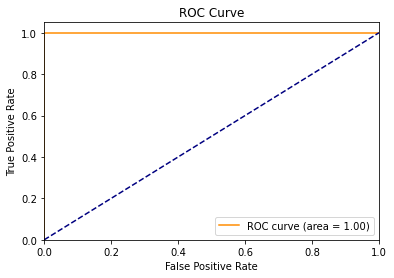

Test Data Metrics:

Confusion Matrix:
 [[14  1]
 [ 0  4]]


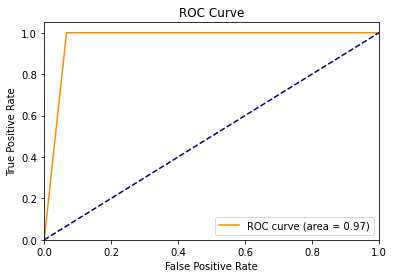

In [38]:
trainx = getfeatureDF(trainFiles, downsample_model_l, selected_features)[downsample_model_features]
trainy = getlabels(trainFiles).iloc[:,:1]
# Indicies of each class' observations
i_class0 = np.where(trainy == 0)[0]
i_class1 = np.where(trainy == 1)[0]
# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation of class 1, randomly sample from class 0 without replacement
i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)

# Join together class 0's target vector with the downsampled class 1's target vector
trainy = pd.DataFrame(np.vstack((trainy.loc[i_class0_downsampled], trainy.loc[i_class1])), columns = trainy.columns)
trainx = pd.DataFrame(np.vstack((trainx.loc[i_class0_downsampled], trainx.loc[i_class1])),columns = trainx.columns)

testx = getfeatureDF(testFiles, downsample_model_l, selected_features)[downsample_model_features]
testy = getlabels(testFiles).iloc[:,:1]

print("Train Data Metrics:\n")
downpredictions = downsample_model.predict(trainx)
metrics(trainy, downpredictions)

print("Test Data Metrics:\n")
testdownpredictions = downsample_model.predict(testx)
metrics(testy, testdownpredictions)


## Binary Classification Using L1-penalized logistic regression

### Repeat 1.4.3 using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization.

In [39]:
y = getlabels(trainFiles).iloc[:,:1]
l1_model_params = []
# Logistic Regression with Cross validation for L
for l in range(1,L+1):
    x = getfeatureDF(trainFiles, l, selected_features)
    
    # Normalize
    scaler = MinMaxScaler()
    train_new = scaler.fit_transform(x)
    train_new = pd.DataFrame(train_new, columns = x.columns)
    
    # Run Logistic Regression with 5-fold Cross validation
    model = LogisticRegression(penalty='l1' , solver='liblinear')
    cv = StratifiedKFold(n_splits=5, shuffle = True)
    f1score = []
    
    for train_idx, validation_idx in cv.split(train_new, y):
        model = model.fit(train_new.loc[train_idx], y.loc[train_idx])
        ypred = model.predict(train_new.loc[validation_idx])
        f1score.append(f1_score(y.loc[validation_idx], ypred, average='weighted'))   
    
    l1_model_params.append((l, np.mean(f1score), model))
    print(l, l1_model_params[-1][1])

1 0.8101978021978022
2 0.8355750915750916
3 0.8355750915750916
4 0.8609523809523811
5 0.8355750915750916
6 0.8609523809523811
7 0.8583443223443222
8 0.8583443223443222
9 0.8355750915750916
10 0.8101978021978022
11 0.8583443223443223
12 0.8101978021978022
13 0.8583443223443223
14 0.8609523809523811
15 0.8329670329670329
16 0.8355750915750917
17 0.8355750915750916
18 0.8355750915750916
19 0.8355750915750917
20 0.8583443223443222


In [40]:
l1_sort_model_params = sorted(l1_model_params, key=lambda x: -x[1])
l1_model_l = l1_sort_model_params[0][0]
l1_model_f1 = l1_sort_model_params[0][1]
l1_model = l1_sort_model_params[0][2]
print('Best model parameters (l, F1-score, Model):\n')
print(l1_sort_model_params[0])

Best model parameters (l, F1-score, Model):

(4, 0.8609523809523811, LogisticRegression(penalty='l1', solver='liblinear'))


In [41]:
trainX = getfeatureDF(trainFiles, l1_model_l, selected_features)
scaler = MinMaxScaler()
train_new = scaler.fit_transform(trainX)
train_new = pd.DataFrame(train_new, columns = trainX.columns)
train_error = round(1 - l1_model.score(train_new,y), 2)

Train Data metrics:

Confusion Matrix:
 [[60  0]
 [ 6  3]]


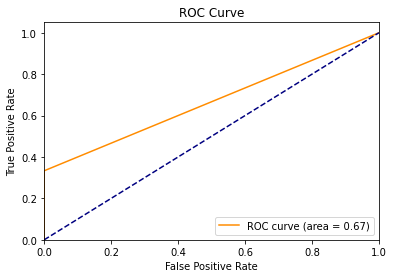

In [42]:
l1_predict = l1_model.predict(train_new)
print("Train Data metrics:\n")
metrics(y, l1_predict)

In [43]:
# Running Classifier on test data
testX = getfeatureDF(testFiles, l1_model_l, selected_features)
scaler = MinMaxScaler()
test_new = scaler.fit_transform(testX)
test_new = pd.DataFrame(test_new, columns = testX.columns)
testY = getlabels(testFiles).iloc[:,:1]
testpredictions = l1_model.predict(test_new)
test_f1score = f1_score(testY, testpredictions, average='weighted')
print('L1-penalized Logistic regression on Test data:\nl:{}'.format(l1_model_l))
print('F1 score: %0.2f '%test_f1score)

L1-penalized Logistic regression on Test data:
l:4
F1 score: 0.94 


In [44]:
test_error = round(1 - l1_model.score(test_new,testY), 2)

Test Data metrics:

Confusion Matrix:
 [[15  0]
 [ 1  3]]


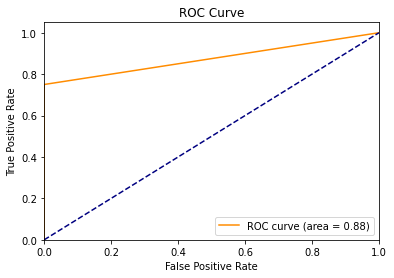

In [45]:
print("Test Data metrics:\n")
metrics(testY, testpredictions)

In [46]:
bestl = str(l1_model_l).strip()
binaryclassVals.loc['L1-penalized Logistic regression'] = [bestl, train_error, test_error, test_f1score]

### Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [47]:
binaryclassVals.index.name = 'Type'
binaryclassVals

,Best l,Train Error,Test Error,F1-score
Type,,,,
Logistic regression with RFE and CV,6,0.01,0.00,1.000000
L1-penalized Logistic regression,4,0.09,0.05,0.944458


These two models both turn out to have good f1-score, but when it comes to the test set and F1-score, model with Logistic regression with RFE and CV performs little better than the L1-penalized Logistic Regression.  As for implementation, L1-penalized model is more easy to deal with, because when using feature selection with RFE in cross validation, it makes it more complex to put into practice.

## Multi-class Classification (The Realistic Case)

### Find the best l in the same way as you found it in 1.5.1 to build an L1-penalized multinomial regression model to classify all activities in your training set.

In [48]:
ytrain = getlabels(trainFiles).iloc[:,1:]
multi_model_params = []
# Logistic Regression with Cross validation for L
for l in range(1,L+1):
    x = getfeatureDF(trainFiles, l, selected_features)
    
    # Normalize
    scaler = MinMaxScaler()
    train_new = scaler.fit_transform(x)
    train_new = pd.DataFrame(train_new, columns = x.columns)
    
    model = LogisticRegression(penalty = 'l1', multi_class='multinomial', solver='saga')
    cv = StratifiedKFold(n_splits=5, shuffle = True)
    f1score = []
    
    # Run Logistic Regression with 5-fold Cross validation
    for train_idx, validation_idx in cv.split(train_new, ytrain):
        model = model.fit(train_new.loc[train_idx], ytrain.loc[train_idx])
        ypred = model.predict(train_new.loc[validation_idx])
        f1score.append(f1_score(ytrain.loc[validation_idx], ypred, average='weighted'))   
    
    multi_model_params.append((l, np.mean(f1score), model))
    print(l, multi_model_params[-1][1])

1 0.713783359497645
2 0.6625013082155939
3 0.6907509157509157
4 0.7240319204604918
5 0.692711494854352
6 0.7060832025117738
7 0.6969788941217512
8 0.7012637362637363
9 0.7072239665096808
10 0.7690633176347462
11 0.6970120355834641
12 0.7271088435374149
13 0.7035661957090528
14 0.7194296180010467
15 0.6953628117913832
16 0.7345368916797488
17 0.7501465201465202
18 0.7025771847200419
19 0.7246049188906333
20 0.6475039246467817


In [49]:
multi_sort_model_params = sorted(multi_model_params, key=lambda x: -x[1])
multi_model_l = multi_sort_model_params[0][0]
multi_model_f1 = round(multi_sort_model_params[0][1], 2)
multi_model = multi_sort_model_params[0][2]
print("Best l for L1 penalized multinomial regression:{} with F1-score = {}".format(multi_model_l, multi_model_f1))

Best l for L1 penalized multinomial regression:10 with F1-score = 0.77


In [51]:
xtest = getfeatureDF(testFiles, multi_model_l, selected_features)
ytest = getlabels(testFiles).iloc[:,1:]
# Normalize
scaler = MinMaxScaler()
_xtest = scaler.fit_transform(xtest)
xtest = pd.DataFrame(_xtest, columns = xtest.columns)

xtrain = getfeatureDF(trainFiles, multi_model_l, selected_features)
# Normalize
scaler = MinMaxScaler()
_xtrain = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(_xtrain, columns = xtrain.columns)

#### Report your test error and train error 

In [52]:
train_multi_predict = multi_model.predict(xtrain)
train_error = round(1 - multi_model.score(xtrain,ytrain), 2)
print("Train error:",train_error)
multi_predict = multi_model.predict(xtest)
test_error = round(1 - multi_model.score(xtest,ytest), 2)
print("Test error:",test_error)

Train error: 0.23
Test error: 0.21


In [53]:
bestl = str(multi_model_l).strip()
multiclassVals.loc['L1-penalized multinomial regression'] = [bestl, train_error, test_error, multi_model_f1]

#### Confusion matrix and ROC for Train data

[[ 3  0  0  0  0  2  0]
 [ 0  0  0  2  1  1  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0  3  9  0]
 [ 0  0  0  1  0 11  0]
 [ 0  0  0  0  0  0 12]]


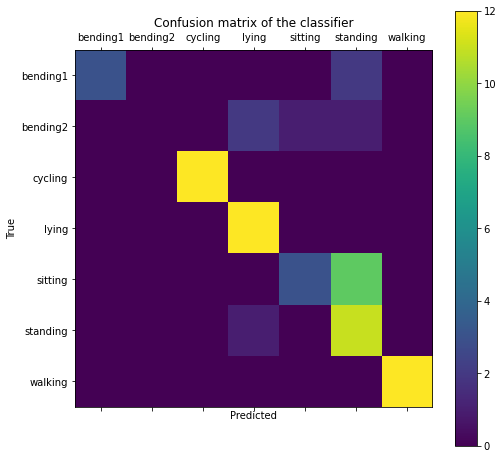

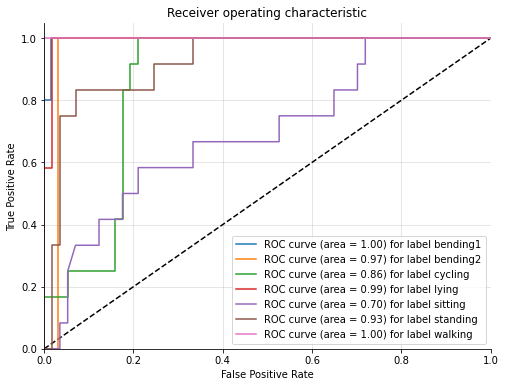

In [54]:
multi_cm(multi_model, xtrain, ytrain)
plot_multiclass_roc(multi_model, xtrain, ytrain)

#### Confusion matrix and ROC for Test data

[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


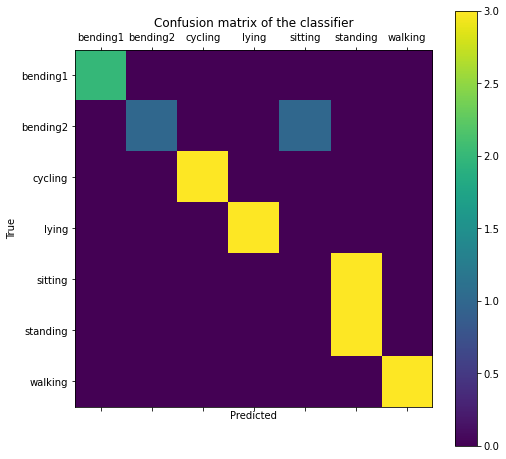

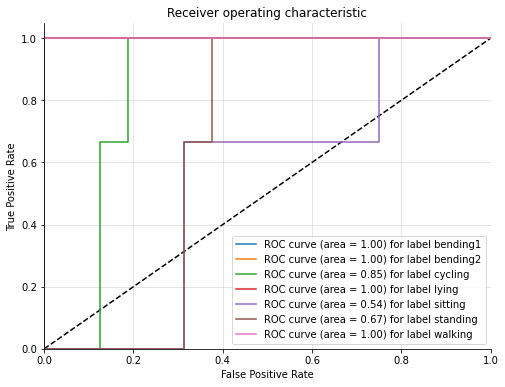

In [55]:
multi_cm(multi_model, xtest, ytest)
plot_multiclass_roc(multi_model, xtest, ytest)

### Repeat 1.6.1 using a Naive Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.

#### Gaussian NB

In [56]:
gaussian_model_params = []
# Logistic Regression with Cross validation for L
for l in range(1,L+1):
    x = getfeatureDF(trainFiles, l, selected_features)
    
    model = GaussianNB()
    cv = StratifiedKFold(n_splits=5, shuffle = True)
    f1score = []
    
    # Run Logistic Regression with 5-fold Cross validation
    for train_idx, validation_idx in cv.split(x, ytrain):
        model = model.fit(x.loc[train_idx], ytrain.loc[train_idx])
        ypred = model.predict(x.loc[validation_idx])
        f1score.append(f1_score(ytrain.loc[validation_idx], ypred, average='weighted'))   
    
    gaussian_model_params.append((l, np.mean(f1score), model))
    print(l, gaussian_model_params[-1][1])

1 0.8184929356357926
2 0.768356881214024
3 0.7444897959183673
4 0.707257980115123
5 0.6986028257456829
6 0.7075300889586604
7 0.6242804814233386
8 0.7066300366300367
9 0.7816326530612245
10 0.7417425431711145
11 0.7510099424385139
12 0.7382626896912612
13 0.6824071166928312
14 0.7517844060701204
15 0.7395395081109367
16 0.7461416361416362
17 0.7487362637362638
18 0.7475248560962846
19 0.7176879469736612
20 0.7006802721088436


In [57]:
gaussian_sort_model_params = sorted(gaussian_model_params, key=lambda x: -x[1])
gaussian_model_l = gaussian_sort_model_params[0][0]
gaussian_model_f1 = gaussian_sort_model_params[0][1]
gaussian_model = gaussian_sort_model_params[0][2]
print("Best l for Gaussian NB classifier:{} with F1-score = {}".format(gaussian_model_l,round(gaussian_model_f1,2)))

Best l for Gaussian NB classifier:1 with F1-score = 0.82


In [58]:
xtest = getfeatureDF(testFiles, gaussian_model_l, selected_features)
xtrain = getfeatureDF(trainFiles, gaussian_model_l, selected_features)
ytest = getlabels(testFiles).iloc[:,1:]

In [59]:
train_error = round(1 - gaussian_model.score(xtrain,ytrain),2)
print("Train error:",train_error)

test_error = round(1 - gaussian_model.score(xtest,ytest),2)
print("Test error:",test_error)

Train error: 0.07
Test error: 0.11


In [60]:
bestl = str(gaussian_model_l).strip()
multiclassVals.loc['Gaussian NB classifier'] = [bestl, train_error, test_error, gaussian_model_f1]

Confusion Matrix and ROC of Gaussian NB classifier for Train data
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1  7  3  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


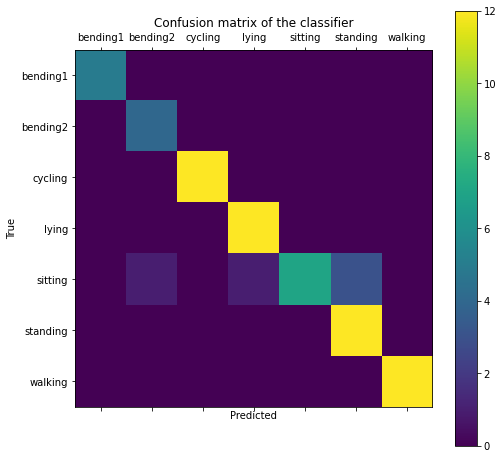

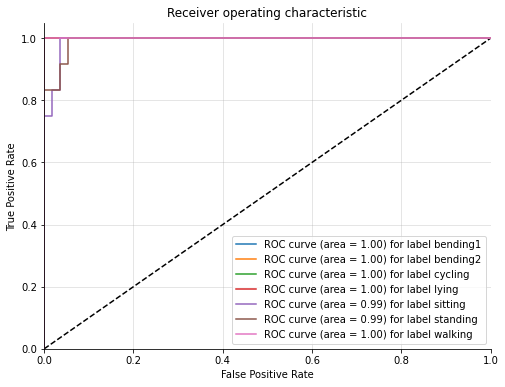

Confusion Matrix and ROC of Gaussian NB classifier for Test data
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


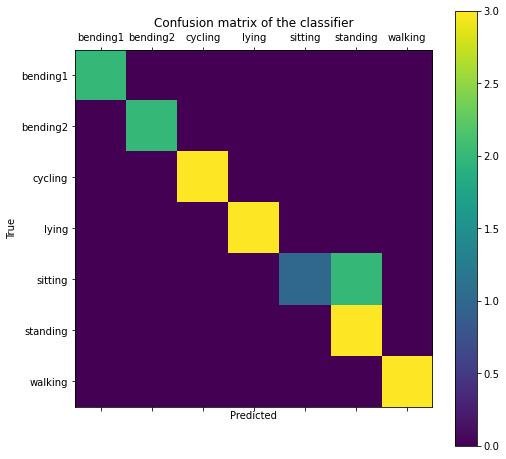

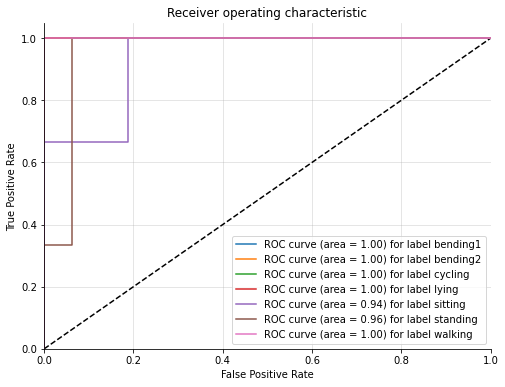

In [61]:
print("Confusion Matrix and ROC of Gaussian NB classifier for Train data")
multi_cm(gaussian_model, xtrain, ytrain)
plot_multiclass_roc(gaussian_model, xtrain, ytrain)

print("Confusion Matrix and ROC of Gaussian NB classifier for Test data")
multi_cm(gaussian_model, xtest, ytest)
plot_multiclass_roc(gaussian_model, xtest, ytest)


#### Multinomial NB

In [62]:
multinomial_model_params = []
# Logistic Regression with Cross validation for L
for l in range(1,L+1):
    x = getfeatureDF(trainFiles, l, selected_features)
    
    model = MultinomialNB()
    cv = StratifiedKFold(n_splits=5, shuffle = True)
    f1score = []
    
    # Run Logistic Regression with 5-fold Cross validation
    for train_idx, validation_idx in cv.split(x, ytrain):
        model = model.fit(x.loc[train_idx], ytrain.loc[train_idx])
        ypred = model.predict(x.loc[validation_idx])
        f1score.append(f1_score(ytrain.loc[validation_idx], ypred, average='weighted'))   
    
    multinomial_model_params.append((l, np.mean(f1score), model))
    print(l, multinomial_model_params[-1][1])

1 0.8266562009419152
2 0.783134484563056
3 0.7346834118262688
4 0.7893223443223444
5 0.7398613291470435
6 0.7735845107273678
7 0.7750863422291994
8 0.7162585034013605
9 0.7810779696493982
10 0.760952380952381
11 0.7279748822605965
12 0.7789638932496075
13 0.782778649921507
14 0.7619675562532704
15 0.7525222396650968
16 0.7614495028780743
17 0.7373888016745159
18 0.7909419152276295
19 0.6942072213500785
20 0.8017582417582417


In [63]:
multinomial_sort_model_params = sorted(multinomial_model_params, key=lambda x: -x[1])
multinomial_model_l = multinomial_sort_model_params[0][0]
multinomial_model_f1 = multinomial_sort_model_params[0][1]
multinomial_model = multinomial_sort_model_params[0][2]
print("Best l for Multinomial NB classifier:{} with F1-score = {}".format(multinomial_model_l,round(multinomial_model_f1,2)))

Best l for Multinomial NB classifier:1 with F1-score = 0.83


In [64]:
xtest = getfeatureDF(testFiles, multinomial_model_l, selected_features)
xtrain = getfeatureDF(trainFiles, multinomial_model_l, selected_features)
ytest = getlabels(testFiles).iloc[:,1:]

In [65]:
train_error = round(1 - multinomial_model.score(xtrain,ytrain),2)
print("Train error:",train_error)

test_error = round(1 - multinomial_model.score(xtest,ytest),2)
print("Test error:",test_error)

Train error: 0.13
Test error: 0.11


In [66]:
bestl = str(multinomial_model_l).strip()
multiclassVals.loc['Multinomial NB classifier'] = [bestl, train_error, test_error, multinomial_model_f1]

Confusion Matrix and ROC of Multinomial NB classifier for Train data
[[ 4  0  0  0  1  0  0]
 [ 1  2  0  0  1  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  0  2  0]
 [ 0  1  0  1  9  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


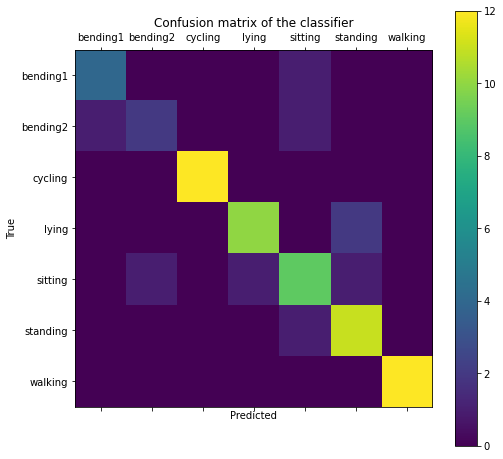

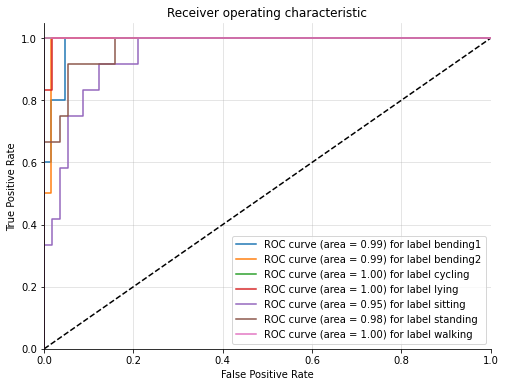

Confusion Matrix and ROC of Multinomial NB classifier for Test data
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


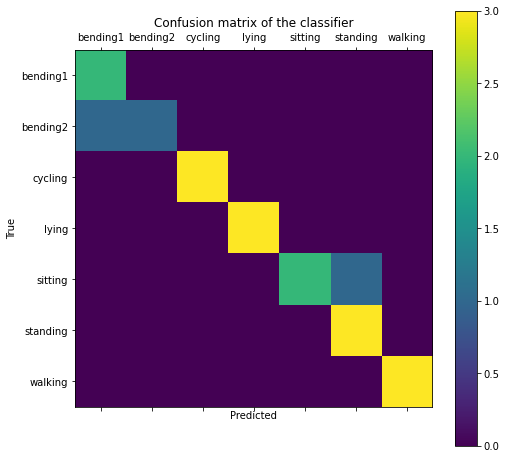

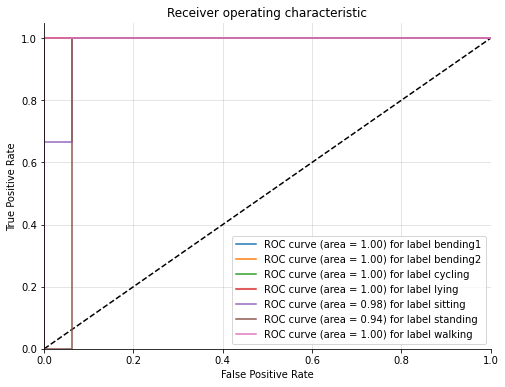

In [67]:
print("Confusion Matrix and ROC of Multinomial NB classifier for Train data")
multi_cm(multinomial_model, xtrain, ytrain)
plot_multiclass_roc(multinomial_model, xtrain, ytrain)

print("Confusion Matrix and ROC of Multinomial NB classifier for Test data")
multi_cm(multinomial_model, xtest, ytest)
plot_multiclass_roc(multinomial_model, xtest, ytest)


### Which method is better for multi-class classification in this problem?

In [68]:
multiclassVals.index.name = 'Type'
multiclassVals

,Best l,Train Error,Test Error,F1-score
Type,,,,
L1-penalized multinomial regression,10,0.23,0.21,0.770000
Gaussian NB classifier,1,0.07,0.11,0.818493
Multinomial NB classifier,1,0.13,0.11,0.826656


Comparing the test error of these three classifiers, L1-penalized logistic regression has a weaker performance in predicting test dataset. I think using L1-penalized logistic regression might have more tendency to cause a more varying error comparing to two other Naive Bayes classifier. In conclusion, with multi-class classification, using Multinomial Naive Bayes Classifier is a more stable way to make prediction, taking the dimension of dataset (p>n) and F1-score into consideration.

# ISLR 3.4.7

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$.

**(a)** Suppose that the true relationship between X and Y is linear, i.e. $Y = \beta_0 + \beta_1X + \epsilon$. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.<br>
**Ans:** *We would expect the training RSS for the cubic regression to be smaller. Even though the true relationship is linear, one extra term in the model will reduce (or at least not increase) the RSS.*

**(b)** Answer (a) using test rather than training RSS.<br>
**Ans:** *Unlike (a), we would expect the test RSS for the cubic regression to be greater than that of the
linear. The reason is that the polynomial model tends to overfit the data.*

**(c)** Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer. <br>
**Ans:** *The training RSS for the cubic regression would be lower because higher flexibility makes fitted
points closer to the observed ones.*

**(d)** Answer (c) using test rather than training RSS. <br>
**Ans:** *There is not enough information to tell since we don’t know how far the underlying relationship
is from linear in this case. If it is closer to linear than cubic, then the linear regression test RSS could
be lower than the cubic, or vice versa otherwise.*

# ISLR 4.7.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.<br>
Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, $X ∼ N(μ_k, σ^2_k)$. Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.

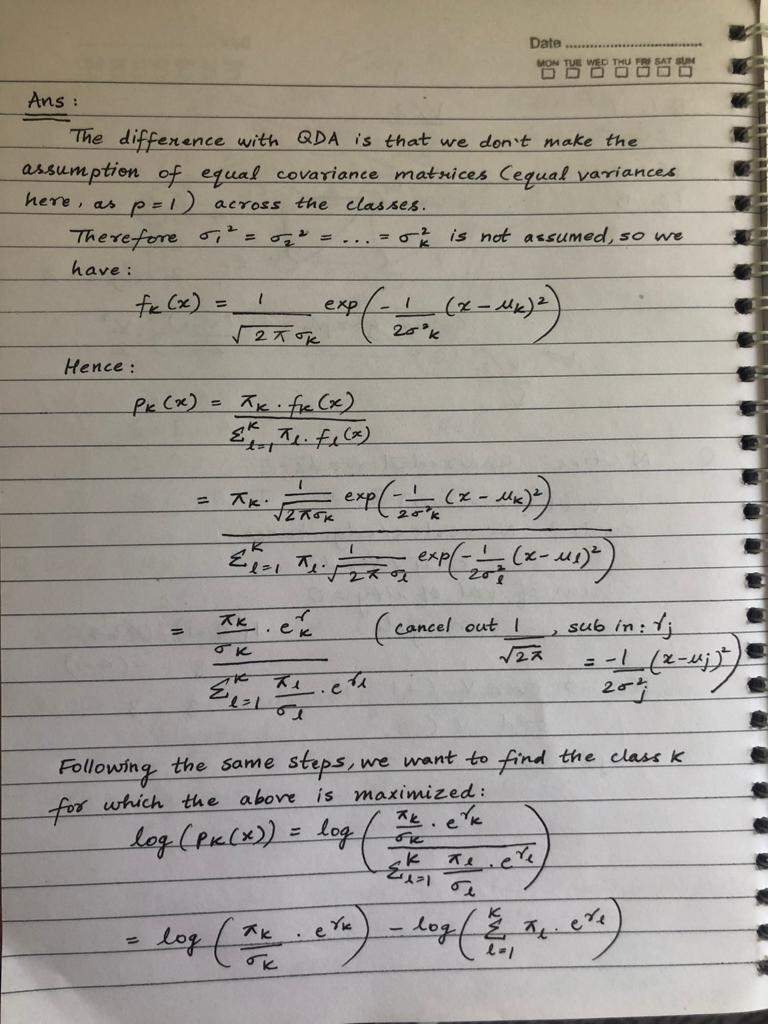

In [69]:
Image("../image/ISLR 4.7.3 Part-1.jpg")

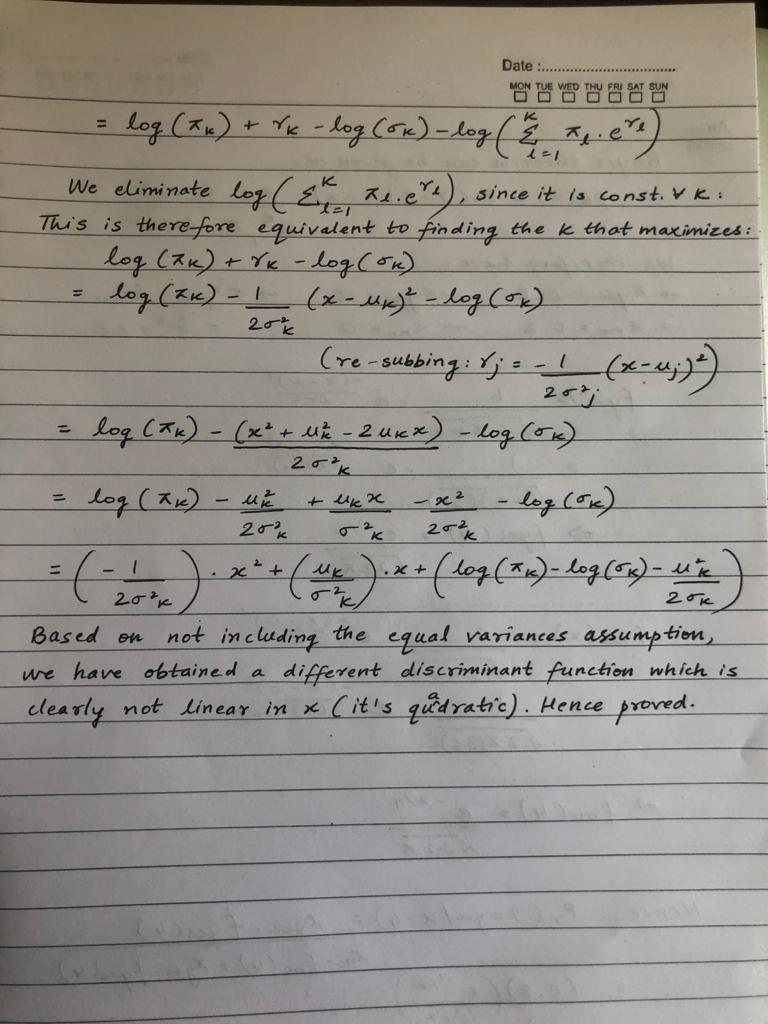

In [70]:
Image("../image/ISLR 4.7.3 Part-2.jpg")

# ISLR 4.7.7

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit.We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was ¯X = 10, while the mean for those that didn’t was ¯X = 0. In addition, the variance of X for these two sets of companies was ˆσ2 = 36. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

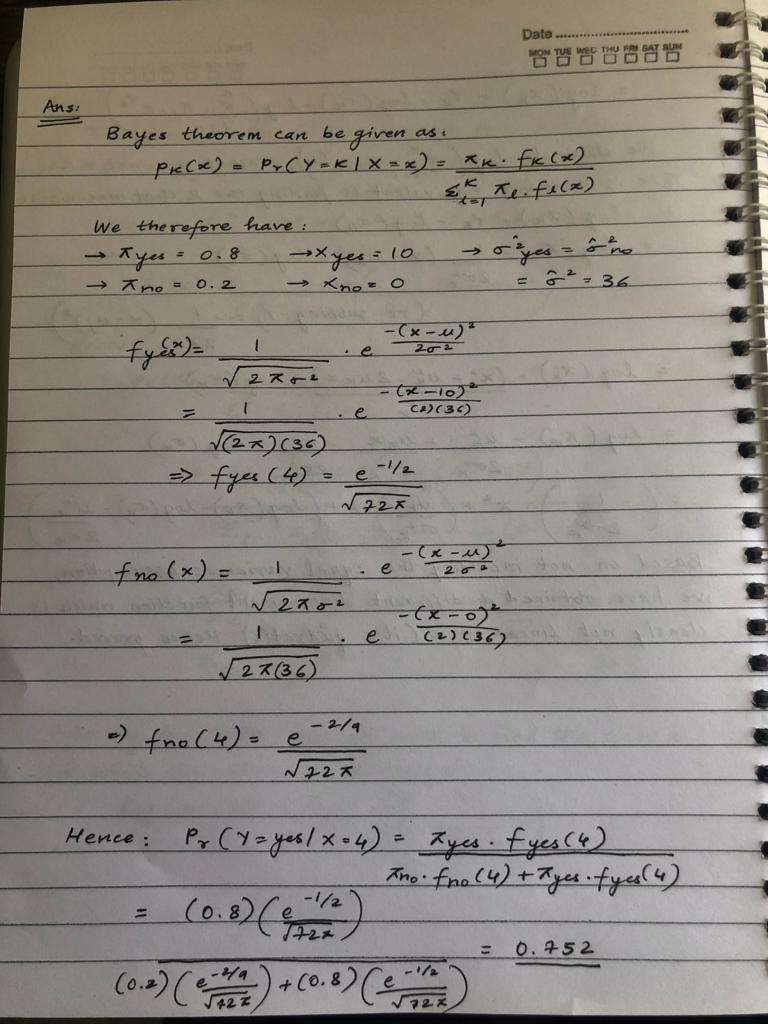

In [71]:
Image("../image/ISLR 4.7.7 Ans.jpg")

In [72]:
round((0.8 * math.exp(-0.5) / math.sqrt(72*math.pi)) / ((0.2 * math.exp(-2/9) / math.sqrt(72*math.pi)) + (0.8 * math.exp(-0.5) / math.sqrt(72*math.pi))), 3)

0.752